In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import os
import shutil

# Access the Dataset

In [2]:
# Acces teh Dataset
import os

#list all files in the input directory
input_dir = '/kaggle/input/cassava-leaf-disease-classification'
os.listdir(input_dir)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

# Load CSV and JSON Files

In [3]:
import pandas as pd
import json

# Load the train.csv file
train_df = pd.read_csv(os.path.join(input_dir, 'train.csv'))

# Load the JSON file for mapping labels to diseases
with open(os.path.join(input_dir, 'label_num_to_disease_map.json')) as f:
    label_map = json.load(f)

# Display the first few rows of the training data
print(train_df.head())

# Display the label mapping
print(label_map)


         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


# Load and Visualize Images

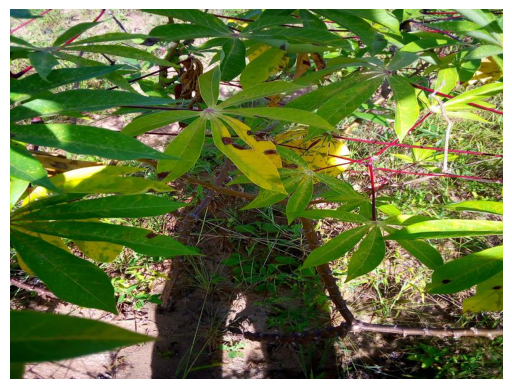

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to load and display an image
def load_and_display_image(image_id):
    image_path = os.path.join(input_dir, 'train_images', image_id)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

# Display a sample image
sample_image_id = train_df['image_id'].iloc[0]
load_and_display_image(sample_image_id)


# Preprocess Images

In [5]:
from PIL import Image
from torchvision import transforms

# Define preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to load an image using PIL
def load_image(image_id):
    image_path = os.path.join('/kaggle/input/cassava-leaf-disease-classification/train_images', image_id)
    img = Image.open(image_path)
    return img

# Example: Load and preprocess the sample image
sample_image_id = train_df['image_id'].iloc[0]  # Replace with actual image ID if needed
img = load_image(sample_image_id)               # Load image
img_tensor = preprocess(img)                    # Apply preprocessing transformations

# Check the shape of the processed image tensor
print(img_tensor.shape)


torch.Size([3, 224, 224])


# Define the Model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Define your CNN model (simple architecture for image classification)
class CassavaCNN(nn.Module):
    def __init__(self, num_classes=5):  # Assuming 5 classes for Cassava leaf disease
        super(CassavaCNN, self).__init__()
        
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)  # Assuming input image size is 64x64
        self.fc2 = nn.Linear(512, num_classes)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 8 * 8)  # Flatten the feature map
        
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


# Prepare Dataset and DataLoader

In [7]:
import os
print(os.listdir("/kaggle/input"))


['cassava-leaf-disease-classification']


In [8]:
import os
print(os.listdir("/kaggle/input/cassava-leaf-disease-classification"))


['train_tfrecords', 'sample_submission.csv', 'test_tfrecords', 'label_num_to_disease_map.json', 'train_images', 'train.csv', 'test_images']


In [9]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

# Load the CSV with image file names and labels
train_df = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')

# Shuffle the dataset and select the first 1000 samples
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the dataset
train_df = train_df[:1000]  # Select the first 1000 samples

# Custom Dataset class to handle loading of images and their labels
class CassavaDataset(Dataset):
    def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx, 0]  # Assuming first column contains image names
        img_path = f"{self.root_dir}/{img_name}"
        image = Image.open(img_path)
        
        label = self.data_frame.iloc[idx, 1]  # Assuming second column contains labels
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define batch size
batch_size = 32  # You can adjust this value depending on your memory constraints

# Create the dataset using the first 1000 samples
train_dataset = CassavaDataset(
    data_frame=train_df,
    root_dir='/kaggle/input/cassava-leaf-disease-classification/train_images',
    transform=transform
)

# Split the dataset into 800 for training and 200 for testing
train_size = 800
test_size = 200
train_subset, test_subset = random_split(train_dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Now 'train_loader' contains 800 samples for training and 'test_loader' contains 200 samples for testing


In [10]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define the custom dataset class
class CassavaDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.data.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Paths to CSV and image directory
csv_file = '/kaggle/input/cassava-leaf-disease-classification/train.csv'
img_dir = '/kaggle/input/cassava-leaf-disease-classification/train_images'

# Create the dataset
train_dataset = CassavaDataset(csv_file=csv_file, img_dir=img_dir, transform=preprocess)

# Create the DataLoader
batch_size = 32
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Example usage (loop through one batch of data)
for images, labels in dataloader:
    print(images.shape, labels.shape)  # Should print: torch.Size([32, 3, 224, 224]), torch.Size([32])
    break


torch.Size([32, 3, 224, 224]) torch.Size([32])


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet50_Weights  # Import the weights enum

# Load a pre-trained model with updated weights argument
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)  # Use DEFAULT weights

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for the desired number of classes (5 in this case)
model.fc = nn.Linear(model.fc.in_features, 5)  # 5 classes for the diseases

# Only the parameters in the final layer (model.fc) will be optimized
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

# Define loss
criterion = nn.CrossEntropyLoss()

# Set the model to training mode
model.train()

# Define number of epochs
num_epochs = 1  # Adjust as needed

# Training loop (simplified example)
for epoch in range(num_epochs):
    for images, labels in dataloader:  # Use a DataLoader to load your data
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 67.4MB/s]


Epoch [1/1], Loss: 1.1856


# Evaluate the Model (Optional)

Test Accuracy: 70.00%


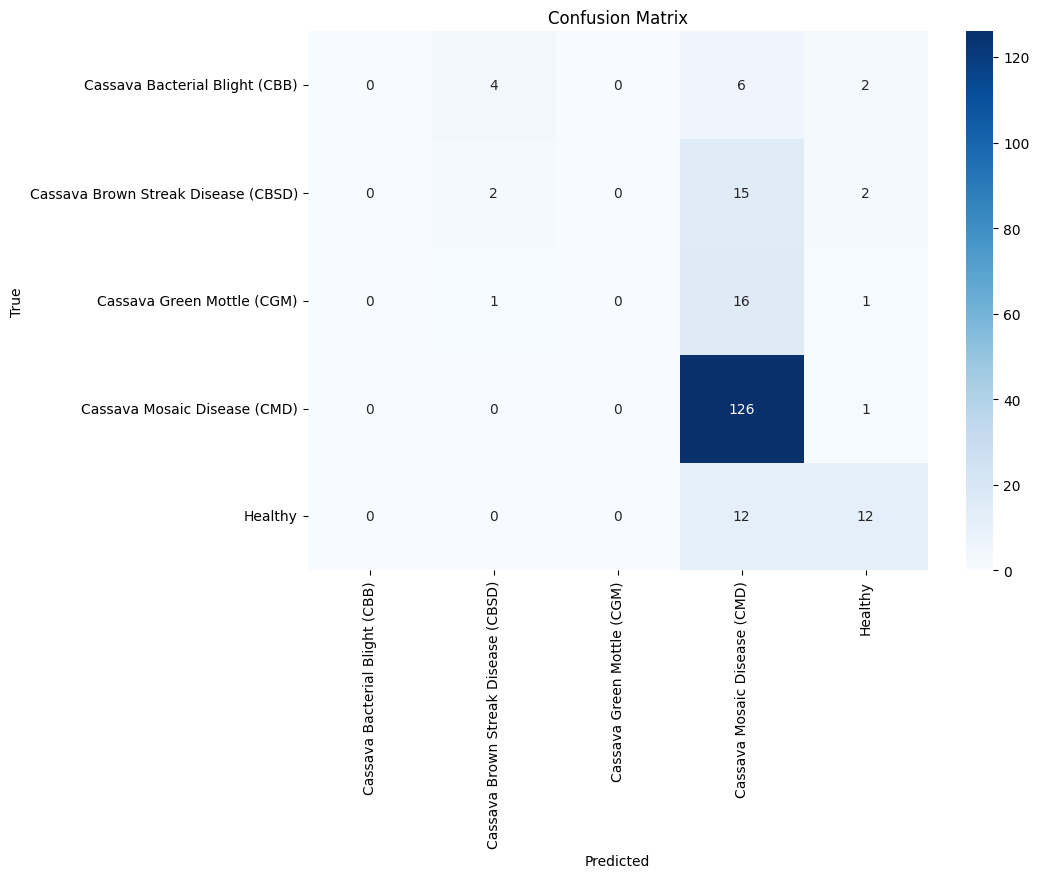

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Initialize variables to collect predictions and labels
all_preds = []
all_labels = []

# Disable gradient calculation for faster inference
with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in test_loader:  # Assuming you have created a test_loader
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Collect predictions and labels
        all_preds.extend(predicted.cpu().numpy())  # Append predictions
        all_labels.extend(labels.cpu().numpy())  # Append true labels

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Now compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# -------------

In [13]:
def grad_cam(input_image, model, target_layer):
    model.eval()
    
    # Lists to store gradients and activations
    activations = []
    gradients = []
    
    # Forward hook to capture activations
    def forward_hook(module, input, output):
        activations.append(output)
    
    # Backward hook to capture gradients
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
    
    # Register hooks
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)
    
    # Forward pass
    x = input_image.requires_grad_()  # Ensure input requires gradient
    output = model(x)
    class_idx = output.argmax(dim=1).item()  # Identify the target class
    
    # Backward pass to calculate gradients for the target class
    model.zero_grad()
    output[:, class_idx].backward()
    
    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()
    
    # Extract activation and gradient tensors
    activation = activations[0].detach()  # Activation from the forward hook
    gradient = gradients[0].detach()  # Gradient from the backward hook

    # Debug: Print shapes of activation and gradients
    print(f"Activation shape: {activation.shape}")
    print(f"Gradient shape: {gradient.shape}")
    
    # Calculate the weights
    weights = gradient.mean(dim=(2, 3), keepdim=True)  # Average gradients spatially
    # Debug: Print the shape of weights
    print(f"Weights shape: {weights.shape}")

    # Calculate the Grad-CAM
    cam = (weights * activation).sum(dim=1, keepdim=True)  # Ensure cam has shape (1, 1, height, width)
    cam = torch.relu(cam)  # Apply ReLU to keep values positive
    
    return cam.squeeze().cpu().numpy()

# Loop for batch processing and calculating feature importance
feature_importances = []
for i in range(images.size(0)):
    cam = grad_cam(images[i].unsqueeze(0), model, model.layer4)  # Generate Grad-CAM for each image
    feature_importances.append(cam.mean())  # Aggregate importance as needed


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activation shape: torch.Size([1, 2048, 7, 7])
Gradient shape: torch.Size([1, 2048, 7, 7])
Weights shape: torch.Size([1, 2048, 1, 1])
Activation shape: torch.Size([1, 2048, 7, 7])
Gradient shape: torch.Size([1, 2048, 7, 7])
Weights shape: torch.Size([1, 2048, 1, 1])
Activation shape: torch.Size([1, 2048, 7, 7])
Gradient shape: torch.Size([1, 2048, 7, 7])
Weights shape: torch.Size([1, 2048, 1, 1])
Activation shape: torch.Size([1, 2048, 7, 7])
Gradient shape: torch.Size([1, 2048, 7, 7])
Weights shape: torch.Size([1, 2048, 1, 1])
Activation shape: torch.Size([1, 2048, 7, 7])
Gradient shape: torch.Size([1, 2048, 7, 7])
Weights shape: torch.Size([1, 2048, 1, 1])
Activation shape: torch.Size([1, 2048, 7, 7])
Gradient shape: torch.Size([1, 2048, 7, 7])
Weights shape: torch.Size([1, 2048, 1, 1])
Activation shape: torch.Size([1, 2048, 7, 7])
Gradient shape: torch.Size([1, 2048, 7, 7])
Weights shape: torch.Size([1, 2048, 1, 1])
Activation shape: torch.Size([1, 2048, 7, 7])
Gradient shape: torch.S

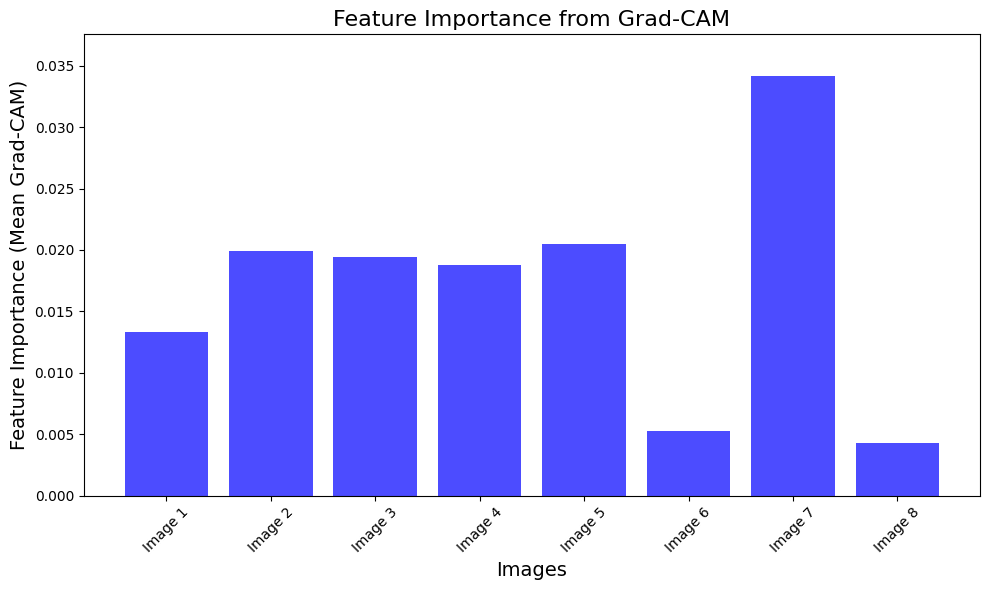

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming feature_importances is a list of means from Grad-CAM outputs
feature_importances = np.array(feature_importances)

# Generate indices for the bars
indices = np.arange(len(feature_importances))

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(indices, feature_importances, color='blue', alpha=0.7)

# Adding labels and title
plt.xlabel('Images', fontsize=14)
plt.ylabel('Feature Importance (Mean Grad-CAM)', fontsize=14)
plt.title('Feature Importance from Grad-CAM', fontsize=16)
plt.xticks(indices, [f'Image {i+1}' for i in indices], fontsize=10, rotation=45)
plt.ylim(0, feature_importances.max() * 1.1)  # Set y-axis limit slightly above max

# Show the plot
plt.tight_layout()
plt.show()


Forward hook triggered. Activation shape: torch.Size([1, 2048, 7, 7])
Backward hook triggered. Gradient shape: torch.Size([1, 2048, 7, 7])
Forward hook triggered. Activation shape: torch.Size([1, 2048, 7, 7])
Backward hook triggered. Gradient shape: torch.Size([1, 2048, 7, 7])
Forward hook triggered. Activation shape: torch.Size([1, 2048, 7, 7])
Backward hook triggered. Gradient shape: torch.Size([1, 2048, 7, 7])
Forward hook triggered. Activation shape: torch.Size([1, 2048, 7, 7])
Backward hook triggered. Gradient shape: torch.Size([1, 2048, 7, 7])
Forward hook triggered. Activation shape: torch.Size([1, 2048, 7, 7])
Backward hook triggered. Gradient shape: torch.Size([1, 2048, 7, 7])
Forward hook triggered. Activation shape: torch.Size([1, 2048, 7, 7])
Backward hook triggered. Gradient shape: torch.Size([1, 2048, 7, 7])
Forward hook triggered. Activation shape: torch.Size([1, 2048, 7, 7])
Backward hook triggered. Gradient shape: torch.Size([1, 2048, 7, 7])
Forward hook triggered. Act

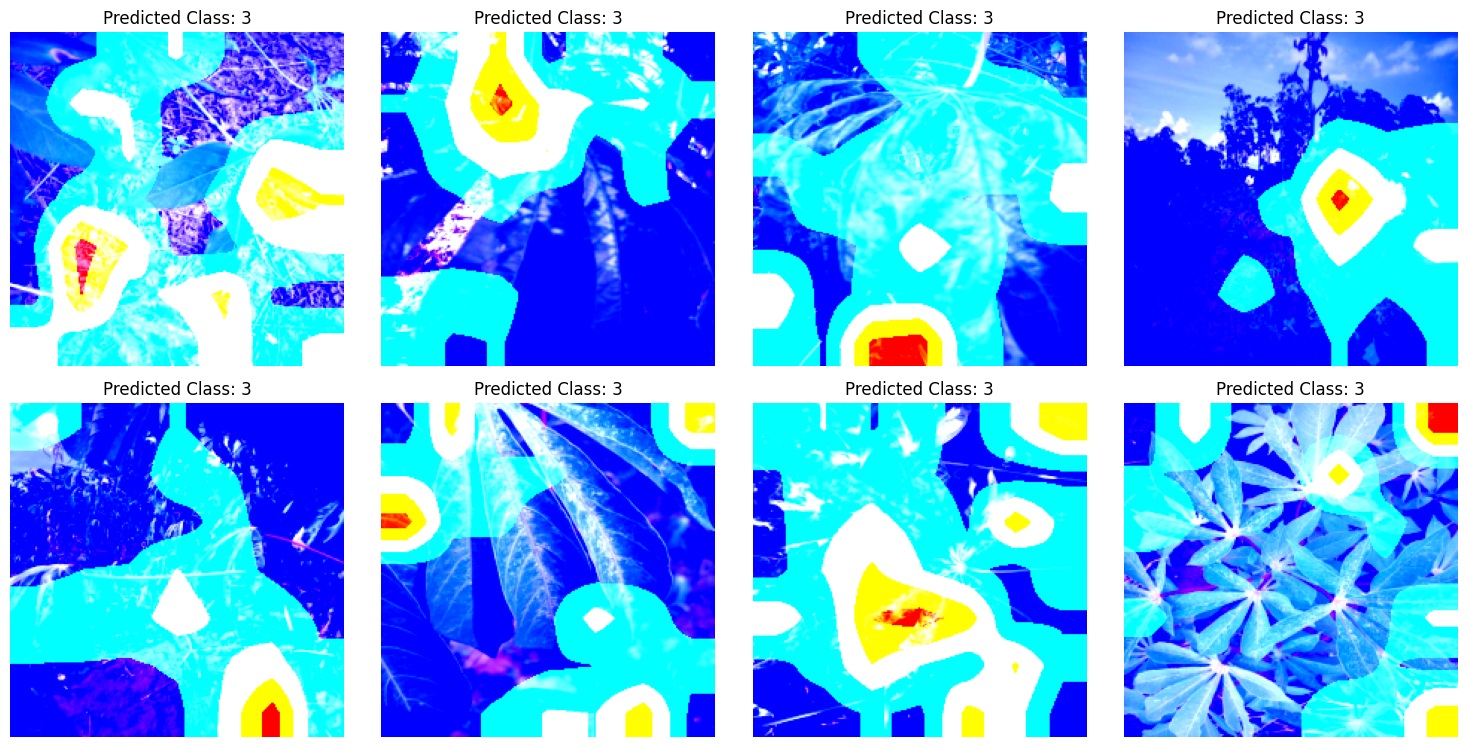

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Function to compute Grad-CAM
def grad_cam(input_image, model, target_layer):
    # Register forward and backward hooks
    activations = []
    gradients = []
    
    def forward_hook(module, input, output):
        activations.append(output)
        print("Forward hook triggered. Activation shape:", output.shape)  # Debug
    
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
        print("Backward hook triggered. Gradient shape:", grad_output[0].shape)  # Debug
    
    # Register hooks
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)
    
    # Forward pass
    model.eval()
    x = input_image.requires_grad_()  # Ensure input requires gradient
    output = model(x)
    target_class = output.argmax(dim=1).item()
    
    # Backward pass
    model.zero_grad()
    output[0, target_class].backward()
    
    # Check if activations and gradients were captured
    if not activations or not gradients:
        raise RuntimeError("Hooks did not capture any activations or gradients.")
    
    # Get the activation and gradient
    activation = activations[0].detach()
    gradient = gradients[0].detach()
    
    # Average the gradients spatially
    weights = torch.mean(gradient, dim=[0, 2, 3], keepdim=True)
    
    # Create the Grad-CAM map
    cam = torch.sum(weights * activation, dim=1).squeeze()
    cam = torch.relu(cam)  # Apply ReLU
    cam = cam.cpu().numpy()
    
    # Normalize the CAM
    cam -= cam.min()
    cam /= cam.max()
    
    # Remove hooks after usage
    forward_handle.remove()
    backward_handle.remove()
    
    return cam, target_class

# Function to generate Grad-CAM images for a batch
def generate_grad_cam_images(images, model, target_layer):
    grad_cam_images = []
    predictions = []
    
    for i in range(images.size(0)):
        cam, pred_class = grad_cam(images[i].unsqueeze(0), model, target_layer)  # Generate Grad-CAM for each image
        cam = cv2.resize(cam, (images.size(2), images.size(3)))  # Resize to match input image size
        cam = np.uint8(255 * cam)  # Scale to [0, 255]
        
        # Create heatmap
        heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert to RGB
        overlay = 0.5 * heatmap + 0.5 * images[i].cpu().numpy().transpose(1, 2, 0)  # Overlay heatmap on image
        
        grad_cam_images.append(overlay)
        predictions.append(pred_class)
        
    return grad_cam_images, predictions

# Function to plot Grad-CAM results
def plot_grad_cam_results(grad_cam_images, predictions):
    plt.figure(figsize=(15, 15))
    for i in range(len(grad_cam_images)):
        plt.subplot(4, 4, i + 1)  # Adjust the number of rows and columns as needed
        plt.imshow(grad_cam_images[i])
        plt.title(f'Predicted Class: {predictions[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming `images` is a tensor of shape (N, C, H, W) and model is already defined
try:
    grad_cam_images, predictions = generate_grad_cam_images(images, model, model.layer4)  # Assuming model.layer4 is the target layer
    plot_grad_cam_results(grad_cam_images, predictions)
except RuntimeError as e:
    print("An error occurred:", e)


# Save the Model (Optional)

In [16]:
# Save the model checkpoint
torch.save(model.state_dict(), 'resnet50_cassava.pth')


In [17]:
# Load the model checkpoint
model.load_state_dict(torch.load('resnet50_cassava.pth'))


/tmp/ipykernel_17/531228027.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet50_cassava.pth'))


<All keys matched successfully>